# South African Language Identification Hackathon

© Explore Data Science Academy 

---
### Honour Code

I **Ngokoana Mokakabye** , confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.



## 1. Introduction

## 2. Importing Libraries

In [1]:
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
%matplotlib inline

import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nlppreprocess import NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer


# Imports for Models
import time 
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer

import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB


/Users/ngokoana/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ngokoana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ngokoana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 3. Loading Dataset

In [2]:
train = pd.read_csv('train_set.csv', encoding='UTF-8')
test = pd.read_csv('test_set.csv' ,encoding='UTF-8')


## 3. EDA

In [4]:
train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [5]:
train.lang_id.describe()

count     33000
unique       11
top         xho
freq       3000
Name: lang_id, dtype: object

In [6]:
#Character Length
train['length'] = train['text'].apply(lambda x: len(x))

In [7]:
train.describe()

,length
count,33000.000000
mean,244.907545
std,28.475588
min,201.000000
25%,220.000000
50%,243.000000
75%,269.000000
max,299.000000


## 4. Data pre-processing

In [17]:


def _remove_punc(x):
    """
    Remove punctuation from the text
    """
    return x.translate(str.maketrans("", "", string.punctuation))

def _lower(x):
    """
    Convert text to lowercase
    """
    return x.lower()

def stemma(x):
    # Snowball Stemming
    stemmer = SnowballStemmer('english')
    words = word_tokenize(x)
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

def lemma(x):
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(x)
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

def _analyzer(x):
    """
    Function combines all the cleaning operations
    """
    #x = _remove_punc(x)
    x = _lower(x)
    x = lemma(x)
    #x = stemma(x)
    return x


In [18]:
# Apply the _analyzer function to the 'Text' column
train['Cleaned_Text'] = train['text'].apply(_analyzer)
test['Cleaned_Text'] = test['text'].apply(_analyzer)


In [19]:
train.head(10)

,lang_id,text,Cleaned_Text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...
5,nso,dinyakišišo tše tša go dirwa gabedi ka ngwaga ...,dinyakišišo tše tša go dirwa gabedi ka ngwaga ...
6,tsn,kgetse nngwe le nngwe e e sa faposiwang mo tsh...,kgetse nngwe le nngwe e e sa faposiwang mo tsh...
7,ven,mbadelo dze dza laelwa dzi do kwama mahatulele...,mbadelo dze dza laelwa dzi do kwama mahatulele...
8,nso,maloko a dikhuduthamaga a ikarabela mongwe le ...,maloko a dikhuduthamaga a ikarabela mongwe le ...
9,tsn,fa le dirisiwa lebone le tshwanetse go bontsha...,fa le dirisiwa lebone le tshwanetse go bontsha...


## 4. Modelling

#### Train Test Split

In [20]:
# Splitting  X (indepedent) and Y (target/dependent) variables
from sklearn.model_selection import train_test_split
X = train['text']
y = train['lang_id']
testX= test['text']

#train_test_split on data for modelling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

#### Testing different classifiers 

In [21]:
# Define classifiers and their names
classifiers = [
    LinearSVC(),
    LogisticRegression(n_jobs=-1),
    KNeighborsClassifier(),
    MultinomialNB(),
    RidgeClassifier(random_state=42)
]

names = [
    'LinearSVC',
    'LogisticRegression',
    'KNeighborsClassifier',
    'MultinomialNB',
    'RidgeClassifier'
]

In [22]:

# Create empty DataFrames to store results
results_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1_Train', 'F1_Test', 'Training Time'])

# A for loop that trains different models and automatically scores their predictions for the final model selection.
for name, clf in zip(names, classifiers):
    print('Fitting {:s} model...'.format(name))

     # Pipeline iterating through all assigned models:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),  # Strings to tokens and then counts tokens on matrix.
        ('classifier', clf),
    ])



      # Capture the start time
    start_time = time.time()

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Capture the end time
    end_time = time.time()

    # Calculate the training time
    training_time = end_time - start_time

    print('... predicting')
    y_pred = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    print('... scoring')
    f1_train = f1_score(y_train, y_pred, average='macro')
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred, average='macro')
    recall = recall_score(y_train, y_pred, average='macro')

    # Save results
    results_df = results_df.append({
        'Classifier': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Train': f1_train,
        'F1_Test': f1_test,
        'Training Time': training_time
    }, ignore_index=True)

# Display the results table
#print(results_df)
print('... All done!')

Fitting LinearSVC model...
... predicting
... scoring


/var/folders/37/wxgq9lms04lb43v25t68xmcw0000gn/T/ipykernel_26599/3842155183.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Fitting LogisticRegression model...


/Users/ngokoana/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/ngokoana/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


... predicting
... scoring


/var/folders/37/wxgq9lms04lb43v25t68xmcw0000gn/T/ipykernel_26599/3842155183.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Fitting KNeighborsClassifier model...
... predicting
... scoring


/var/folders/37/wxgq9lms04lb43v25t68xmcw0000gn/T/ipykernel_26599/3842155183.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Fitting MultinomialNB model...
... predicting
... scoring


/var/folders/37/wxgq9lms04lb43v25t68xmcw0000gn/T/ipykernel_26599/3842155183.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Fitting RidgeClassifier model...
... predicting
... scoring
... All done!


/var/folders/37/wxgq9lms04lb43v25t68xmcw0000gn/T/ipykernel_26599/3842155183.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [23]:
results_df.sort_values('F1_Train', ascending=False)

,Classifier,Accuracy,Precision,Recall,F1_Train,F1_Test,Training Time
0,LinearSVC,1.0,1.0,1.0,1.0,0.996744,1.586721
4,RidgeClassifier,1.0,1.0,1.0,1.0,0.997198,2.871174
3,MultinomialNB,0.999798,0.999798,0.999798,0.999798,0.998712,1.141087
1,LogisticRegression,0.999444,0.999445,0.999444,0.999445,0.994924,20.852059
2,KNeighborsClassifier,0.976566,0.976669,0.976566,0.976434,0.964008,0.995681


<AxesSubplot:title={'center':'Performance vs. Training time'}>

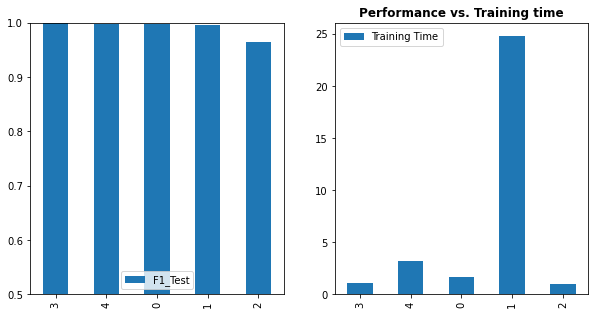

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.title('Performance vs. Training time',fontweight ="bold")
results_df.sort_values('F1_Test', ascending=False, inplace=True)
results_df.plot(y=['F1_Test'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.5,1])
results_df.plot(y='Training Time', kind='bar', ax=ax[1])

In [12]:
print('Classification Report:\n', classification_report(y_train, y_pred))

Classification Report:
               precision    recall  f1-score   support

         afr       1.00      1.00      1.00      1800
         eng       1.00      1.00      1.00      1800
         nbl       1.00      1.00      1.00      1800
         nso       1.00      1.00      1.00      1800
         sot       1.00      1.00      1.00      1800
         ssw       1.00      1.00      1.00      1800
         tsn       1.00      1.00      1.00      1800
         tso       1.00      1.00      1.00      1800
         ven       1.00      1.00      1.00      1800
         xho       1.00      1.00      1.00      1800
         zul       1.00      1.00      1.00      1800

    accuracy                           1.00     19800
   macro avg       1.00      1.00      1.00     19800
weighted avg       1.00      1.00      1.00     19800



### Fitting to test data

In [13]:
 # Pipeline iterating through all assigned models:
best_pipe = Pipeline([
        ('tfidf', TfidfVectorizer()),  # Strings to tokens and then counts tokens on matrix.
        ('classifier', MultinomialNB()),
    ])

best_pipe.fit(X,y)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('classifier', MultinomialNB())])

In [14]:
y_pred = best_pipe.predict(testX)
y_pred

array(['tsn', 'nbl', 'ven', ..., 'sot', 'sot', 'tso'], dtype='<U3')

In [15]:
test['lang_id'] = y_pred.tolist()

#subset columns for output format
df_final_sub = test[['index', 'lang_id']]
df_final_sub


,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr
...,...,...
5677,5678,eng
5678,5679,nso
5679,5680,sot
5680,5681,sot


In [16]:
df_final_sub.to_csv('NK_pred.csv', index=False)